# Home Credit Default Risk

We have a dataframe in which are registered a lot of information about a bank's clients.

The bank wants to know if they should give them a loan or not. The machine learning model needs to predict if the client will repay the loan or not.

If the target is equal to 0: the loan was repaid, if it's equal to 1: the loan was not repaid.

The models will determine if the loan will be repaid or not according to the given features.

# Summary

* Data observation
* Data cleanup

Machine Learning Models: 
* Logistic Regression
* Decision Tree
* Random Forest
* XGBoost

* Comparing models predictions on application test

# Library used

In [108]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import graphviz

# Machine Learning Library
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import joblib

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

## Data

In [109]:
app_train = pd.read_csv("./resources/application_train.csv", encoding='utf-8', sep=',')
app_test = pd.read_csv("./resources/application_test.csv", encoding='utf-8', sep=',')
app_train.drop_duplicates()
app_test.drop_duplicates()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


## Aligning the two datasets

In [110]:
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


# Data Analysis

In [111]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

## Is data unbalanced ? 

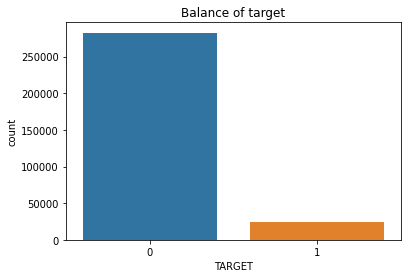

In [112]:
fig = sns.countplot(x="TARGET", data=app_train)
plt.title('Balance of target')
plt.show()

In [113]:
print("Unbalanced data on the TARGET column:")
print(app_train['TARGET'].value_counts())

Unbalanced data on the TARGET column:
0    282686
1     24825
Name: TARGET, dtype: int64


The data is very unbalanced.

## Handling unbalanced data

In [114]:
msk = app_train['TARGET'] == 1
num_to_oversample = len(app_train) - 2*msk.sum()
df_positive_oversample = app_train[msk].sample(n=num_to_oversample, replace=True)
df_train_oversample = pd.concat([app_train, df_positive_oversample])
app_train = df_train_oversample
print("Balanced data after oversampling:\n")
print(app_train['TARGET'].value_counts())

Balanced data after oversampling:

1    282686
0    282686
Name: TARGET, dtype: int64


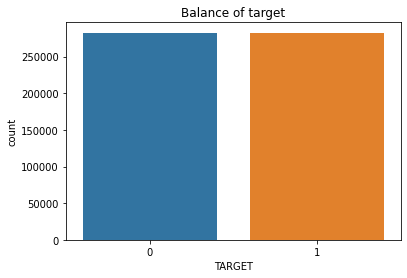

In [115]:
fig = sns.countplot(x="TARGET", data=app_train)
plt.title('Balance of target')
plt.show()

The target column is now balanced, this will allow the models to get better results.

## Gender distribution

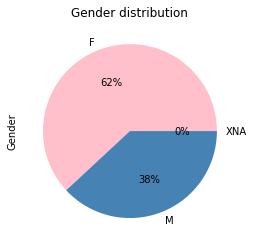

In [116]:
gender_group = app_train.groupby(['CODE_GENDER'])
gender_group.size().plot(kind='pie', 
                         ylabel='Gender', 
                         colors=['pink', 'steelblue', 'pink'], 
                         title='Gender distribution',
                         autopct='%.0f%%')
plt.show()

### Contract type distribution

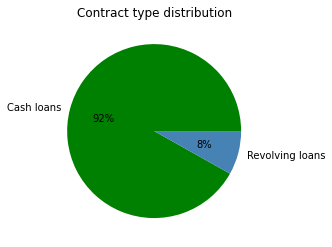

In [117]:
contract_group = app_train.groupby(['NAME_CONTRACT_TYPE'])
contract_group.size().plot(kind='pie', 
                           ylabel='', 
                           colors=['green', 'steelblue'], 
                           title='Contract type distribution',
                           autopct='%.0f%%')
plt.show()

## Days Birth feature

### Informations

In [118]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    565372.000000
mean         42.497022
std          11.843747
min          20.517808
25%          32.550685
50%          41.276712
75%          52.084932
max          69.120548
Name: DAYS_BIRTH, dtype: float64

### Minimum and maximum value

In [119]:
mini = abs(app_train['DAYS_BIRTH'].max())
if mini > 365:
    print("Days birth min :", mini/365, "days" )
else:
    print("Days birth min :", mini, "days" )
    
maxi = abs(app_train['DAYS_BIRTH'].min())
print("Days birth max :", maxi/365, "years" )

Days birth min : 20.517808219178082 days
Days birth max : 69.12054794520547 years


### Boxplots

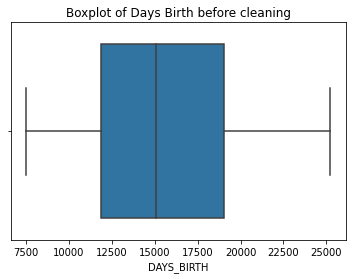

In [120]:
ax = sns.boxplot(x=abs(app_train['DAYS_BIRTH']))
plt.title('Boxplot of Days Birth before cleaning')
plt.show()

## Missing values

In [121]:
print("30 first columns filled with the most NaN values with their percentage:")
((app_train.isnull().sum()/app_train.shape[0])*100).sort_values(ascending=False).head(30)

30 first columns filled with the most NaN values with their percentage:


COMMONAREA_MODE             71.807942
COMMONAREA_AVG              71.807942
COMMONAREA_MEDI             71.807942
NONLIVINGAPARTMENTS_MEDI    71.405022
NONLIVINGAPARTMENTS_AVG     71.405022
NONLIVINGAPARTMENTS_MODE    71.405022
FONDKAPREMONT_MODE          70.448660
LIVINGAPARTMENTS_MEDI       70.433803
LIVINGAPARTMENTS_AVG        70.433803
LIVINGAPARTMENTS_MODE       70.433803
FLOORSMIN_MEDI              69.926703
FLOORSMIN_AVG               69.926703
FLOORSMIN_MODE              69.926703
YEARS_BUILD_AVG             68.725901
YEARS_BUILD_MEDI            68.725901
YEARS_BUILD_MODE            68.725901
OWN_CAR_AGE                 67.630339
LANDAREA_AVG                61.825842
LANDAREA_MODE               61.825842
LANDAREA_MEDI               61.825842
BASEMENTAREA_MODE           61.240564
BASEMENTAREA_MEDI           61.240564
BASEMENTAREA_AVG            61.240564
NONLIVINGAREA_AVG           58.125270
NONLIVINGAREA_MODE          58.125270
NONLIVINGAREA_MEDI          58.125270
EXT_SOURCE_1

# Data cleanup 

## Label encoding

In [122]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        le.fit(app_train[col])
        app_train[col] = le.transform(app_train[col])
        app_test[col] = le.transform(app_test[col])
        le_count += 1
        print(col)
app_train.reset_index()
app_test.reset_index()
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE
16 columns were label encoded.


## Missing and infinite values

In [68]:
# Replacing Infinite values with NaN values
app_train.replace([np.inf, -np.inf], np.nan, inplace=True)
app_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [69]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median").fit(app_train)
imputer = imputer.fit_transform(app_train)
app_train = pd.DataFrame(imputer, columns = app_train.columns.values.tolist())

In [133]:
imputer = SimpleImputer(missing_values=np.nan, strategy="median").fit(app_test)
imputer = imputer.fit_transform(app_test)
app_test = pd.DataFrame(imputer, columns = app_test.columns.values.tolist())

## Days Employed feature

### Informations 

In [71]:
app_train['DAYS_EMPLOYED'].describe()

count    565372.00000
mean      54059.30161
std      132228.28794
min      -17912.00000
25%       -2473.00000
50%       -1121.00000
75%        -336.00000
max      365243.00000
Name: DAYS_EMPLOYED, dtype: float64

### Minimum and maximum values

In [72]:
mini = abs(app_train['DAYS_EMPLOYED'].max())
if mini > 365:
    print("Days employed min :", mini/365, "years" )
else:
    print("Days employed min :", mini, "days" )
    
maxi = abs(app_train['DAYS_EMPLOYED'].min())
print("Days employed max :", maxi/365, "years" )

Days employed min : 1000.6657534246575 years
Days employed max : 49.07397260273972 years


We can see an anomaly : the biggest 'Days Employed' value is around 1000 years !

### Boxplots

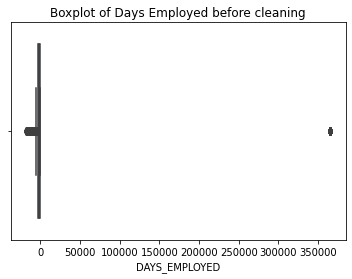

In [73]:
ax = sns.boxplot(x=app_train['DAYS_EMPLOYED'])
plt.title('Boxplot of Days Employed before cleaning')
plt.show()

### Removing anomalies

In [74]:
app_train.drop(app_train.index[(app_train["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)
app_test.drop(app_test.index[(app_test["DAYS_EMPLOYED"] > 12000)], axis=0, inplace=True)

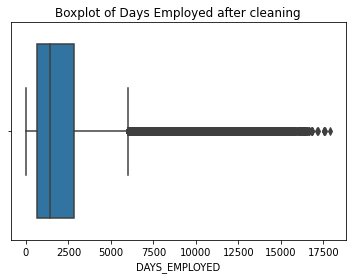

In [75]:
ax = sns.boxplot(x=abs(app_train['DAYS_EMPLOYED']))
plt.title('Boxplot of Days Employed after cleaning')
plt.show()

# Making our model

## Correlations

In [76]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n')
print(correlations.tail(15))
print('\nMost Negative Correlations:\n')
print(correlations.head(15))

Most Positive Correlations:

REG_CITY_NOT_LIVE_CITY         0.067517
DAYS_ID_PUBLISH                0.069406
WALLSMATERIAL_MODE             0.073645
REG_CITY_NOT_WORK_CITY         0.074944
HOUSETYPE_MODE                 0.076151
FLAG_DOCUMENT_3                0.078234
EMERGENCYSTATE_MODE            0.078875
CODE_GENDER                    0.085964
DAYS_LAST_PHONE_CHANGE         0.110099
REGION_RATING_CLIENT           0.114688
DAYS_BIRTH                     0.116555
REGION_RATING_CLIENT_W_CITY    0.118669
NAME_EDUCATION_TYPE            0.122523
DAYS_EMPLOYED                  0.145547
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:

EXT_SOURCE_2                 -0.274686
EXT_SOURCE_3                 -0.268712
EXT_SOURCE_1                 -0.189696
AMT_GOODS_PRICE              -0.095161
FLOORSMAX_AVG                -0.084016
FLOORSMAX_MEDI               -0.083457
FLOORSMAX_MODE               -0.081934
ELEVATORS_AVG                -0.076113


# Splitting data into train and validation

In [77]:
Xdf = app_train
Xdf.drop("TARGET", axis = 1)
X = np.array(Xdf)

y = np.array(app_train["TARGET"])

In [78]:
# Recommended test sizes for crossvalidation : [20, 25, 30]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)

# Logistic regression

Our problem is a very binary one : will someone repay their credit or won't they ? 

This is why we use logistic regression as our machine learning model.

## Model training

In [123]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression()

## Model testing

In [145]:
y_pred = LR.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [1. 1. 1. ... 1. 1. 0.] 

Real values:

 [0. 1. 1. ... 0. 0. 1.]


## Model evaluation

### Confusion Matrix

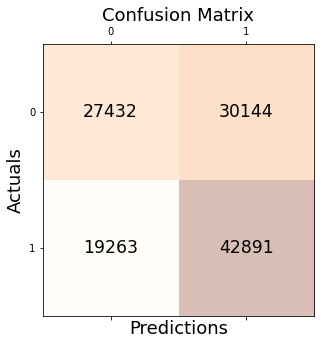

The confusion matrix shows us the number of :

* True positives : 27432 

* True negatives : 30144 

* False positives: 19263 

* False negatives: 42891 



In [131]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### Classification Report

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.48      0.53     57576
         1.0       0.59      0.69      0.63     62154

    accuracy                           0.59    119730
   macro avg       0.59      0.58      0.58    119730
weighted avg       0.59      0.59      0.58    119730



### Accuracy Score

In [127]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 58.73 %

Accuracy score using cross validation: 58.67 %



Model accuracy is a machine learning model performance metric that is defined as the ratio of true positives and true negatives to all positive and negative observations.

The accuracy rate is great but it doesn’t tell us anything about the errors our machine learning models make on new data we haven’t seen before.

Mathematically, it represents the ratio of the sum of true positive and true negatives out of all the predictions.

### Precision Score

In [85]:
print("Precision score:", round((precision_score(y_test, y_pred, average='macro')*100), 2), '%\n')

Precision score: 58.74 %



The precision score is a useful measure of the success of prediction when the classes are very imbalanced.

Mathematically, it represents the ratio of true positive to the sum of true positive and false positive.

### Recall Score

In [86]:
print("Recall score:", round((metrics.recall_score(y_test, y_pred)*100), 2), '%\n')

Recall score: 69.01 %



Model recall score represents the model’s ability to correctly predict the positives out of actual positives. This is unlike precision which measures how many predictions made by models are actually positive out of all positive predictions made.

Recall score is a useful measure of success of prediction when the classes are very imbalanced. 

Mathematically, it represents the ratio of true positive to the sum of true positive and false negative.

### F1 Score

In [87]:
print("F1 Score:", round((metrics.f1_score(y_test, y_pred))*100), 2, '%\n')

F1 Score: 63 2 %



F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively.

### ROC Curve

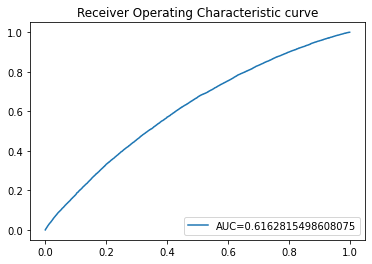

In [88]:
prediction_prob = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  prediction_prob)
auc = metrics.roc_auc_score(y_test, prediction_prob)

#create ROC curve
plt.title("Receiver Operating Characteristic curve")
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()

This curve displays the percentage of true positives predicted by the model as the prediction probability cutoff is lowered from 1 to 0.

The higher the AUC (area under the curve), the more accurately our model is able to predict outcomes.

## Using our LR model on application test

In [137]:
app_test_LR = app_test.copy()
app_test_LR['TARGET'] = 0
app_test_LR

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,100001.0,0.0,0.0,0.0,1.0,0.0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100005.0,0.0,1.0,0.0,1.0,0.0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
2,100013.0,0.0,1.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0
3,100028.0,0.0,0.0,0.0,1.0,2.0,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
4,100038.0,0.0,1.0,1.0,0.0,1.0,180000.0,625500.0,32067.0,625500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221.0,0.0,0.0,0.0,1.0,0.0,121500.0,412560.0,17473.5,270000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
48740,456222.0,0.0,0.0,0.0,0.0,2.0,157500.0,622413.0,31909.5,495000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
48741,456223.0,0.0,0.0,1.0,1.0,1.0,202500.0,315000.0,33205.5,315000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0
48742,456224.0,0.0,1.0,0.0,0.0,0.0,225000.0,450000.0,25128.0,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0


Application test doesn't have a TARGET column. 

That's why after the prediction, we can not see if our model finds the right value.

In [148]:
y_pred_test = LR.predict(app_test_LR)
app_test_LR['TARGET'] = y_pred_test.astype(int)
print(app_test_LR['TARGET'])

0        1
1        0
2        1
3        0
4        0
        ..
48739    1
48740    1
48741    1
48742    0
48743    1
Name: TARGET, Length: 48744, dtype: int32


# Decision Tree

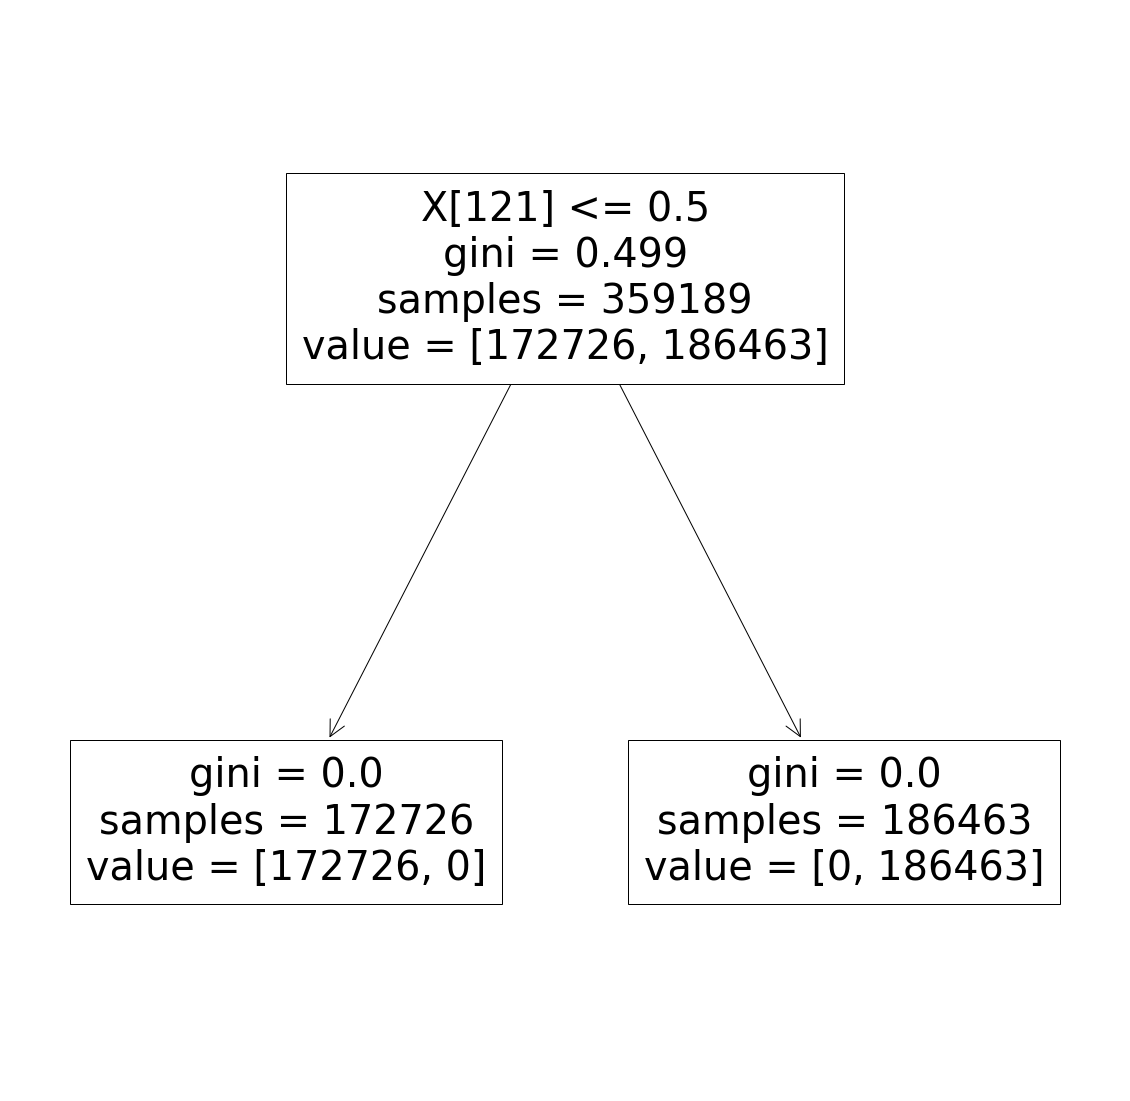

In [89]:
DT = DecisionTreeClassifier(criterion='gini')
DT.fit(X_train, y_train)
plt.figure(figsize=(20,20))
tree.plot_tree(DT)
plt.show()

## Model testing

In [91]:
y_pred = DT.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0. 1. 1. ... 0. 0. 1.] 

Real values:

 [0. 1. 1. ... 0. 0. 1.]


## Model evaluation

### Confusion Matrix

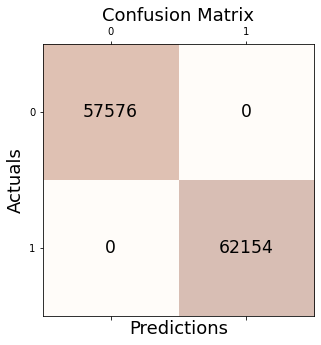

The confusion matrix shows us the number of :

* True positives : 57576 

* True negatives : 0 

* False positives: 0 

* False negatives: 62154 



In [92]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### Classification report

In [93]:
print("Classification report:\n\n", classification_report(y_test, y_pred))

Classification report:

               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57576
         1.0       1.00      1.00      1.00     62154

    accuracy                           1.00    119730
   macro avg       1.00      1.00      1.00    119730
weighted avg       1.00      1.00      1.00    119730



### Accuracy Score

In [94]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(DT, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 100.0 %

Accuracy score using cross validation: 100.0 %



## Using our DT model on application test

In [152]:
app_test_DT = app_test.copy()
app_test_DT['TARGET'] = 0
app_test_DT

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,100001.0,0.0,0.0,0.0,1.0,0.0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100005.0,0.0,1.0,0.0,1.0,0.0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
2,100013.0,0.0,1.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0
3,100028.0,0.0,0.0,0.0,1.0,2.0,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
4,100038.0,0.0,1.0,1.0,0.0,1.0,180000.0,625500.0,32067.0,625500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221.0,0.0,0.0,0.0,1.0,0.0,121500.0,412560.0,17473.5,270000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
48740,456222.0,0.0,0.0,0.0,0.0,2.0,157500.0,622413.0,31909.5,495000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
48741,456223.0,0.0,0.0,1.0,1.0,1.0,202500.0,315000.0,33205.5,315000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0
48742,456224.0,0.0,1.0,0.0,0.0,0.0,225000.0,450000.0,25128.0,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0


In [153]:
y_pred_test = DT.predict(app_test_LR)
app_test_DT['TARGET'] = y_pred_test.astype(int)
print(app_test_DT['TARGET'])

0        1
1        0
2        1
3        0
4        0
        ..
48739    1
48740    1
48741    1
48742    0
48743    1
Name: TARGET, Length: 48744, dtype: int32


# Random Forest

In [95]:
RF = RandomForestClassifier()

In [96]:
RF.fit(X_train, y_train)

RandomForestClassifier()

## Model testing

In [97]:
y_pred = RF.predict(X_test)
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0. 1. 1. ... 0. 0. 1.] 

Real values:

 [0. 1. 1. ... 0. 0. 1.]


## Model evaluation

### Confusion Matrix

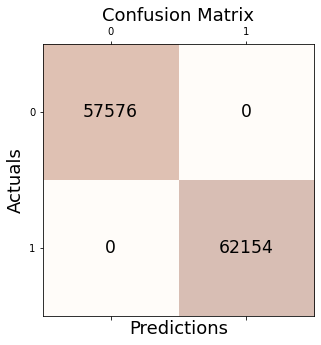

The confusion matrix shows us the number of :

* True positives : 57576 

* True negatives : 0 

* False positives: 0 

* False negatives: 62154 



In [98]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

### Classification Report

In [99]:
print("Classification report:", classification_report(y_test, y_pred))

Classification report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57576
         1.0       1.00      1.00      1.00     62154

    accuracy                           1.00    119730
   macro avg       1.00      1.00      1.00    119730
weighted avg       1.00      1.00      1.00    119730



### Accuracy Score

In [100]:
print("Accuracy score:", round((accuracy_score(y_test, y_pred)*100), 2), '%\n')
print("Accuracy score using cross validation:", 
      round((cross_val_score(RF, X_train, y_train, cv=3, scoring='accuracy').mean())*100, 2), '%\n')

Accuracy score: 100.0 %

Accuracy score using cross validation: 100.0 %



## Using our RF model on application test

In [154]:
app_test_RF = app_test.copy()
app_test_RF['TARGET'] = 0
app_test_RF

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,100001.0,0.0,0.0,0.0,1.0,0.0,135000.0,568800.0,20560.5,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100005.0,0.0,1.0,0.0,1.0,0.0,99000.0,222768.0,17370.0,180000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
2,100013.0,0.0,1.0,1.0,1.0,0.0,202500.0,663264.0,69777.0,630000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0
3,100028.0,0.0,0.0,0.0,1.0,2.0,315000.0,1575000.0,49018.5,1575000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0
4,100038.0,0.0,1.0,1.0,0.0,1.0,180000.0,625500.0,32067.0,625500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221.0,0.0,0.0,0.0,1.0,0.0,121500.0,412560.0,17473.5,270000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
48740,456222.0,0.0,0.0,0.0,0.0,2.0,157500.0,622413.0,31909.5,495000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
48741,456223.0,0.0,0.0,1.0,1.0,1.0,202500.0,315000.0,33205.5,315000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0
48742,456224.0,0.0,1.0,0.0,0.0,0.0,225000.0,450000.0,25128.0,450000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0


In [155]:
y_pred_test = RF.predict(app_test_LR)
app_test_RF['TARGET'] = y_pred_test.astype(int)
print(app_test_RF['TARGET'])

0        1
1        0
2        1
3        0
4        0
        ..
48739    1
48740    1
48741    1
48742    0
48743    1
Name: TARGET, Length: 48744, dtype: int32


# XGBoost

In [101]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Model training

In [157]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations
XGBst = xgb.train(param, dtrain, num_round)

[15:24:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:24:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [158]:
XGBst.dump_model('dump.raw.txt')
f = open('dump.raw.txt', 'r')
print(f.read())

booster[0]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.449994147
	2:leaf=-0.224997312
booster[1]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.224997088
	2:leaf=0.449994594
booster[2]:
0:leaf=-0.224998608
booster[3]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.302744657
	2:leaf=-0.200604156
booster[4]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.200603977
	2:leaf=0.302744836
booster[5]:
0:leaf=-0.200605482
booster[6]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.24233368
	2:leaf=-0.185299397
booster[7]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.185299188
	2:leaf=0.242333815
booster[8]:
0:leaf=-0.185300842
booster[9]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.210205182
	2:leaf=-0.175068453
booster[10]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.17506817
	2:leaf=0.210205317
booster[11]:
0:leaf=-0.175070167
booster[12]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=0.190954134
	2:leaf=-0.16801405
booster[13]:
0:[f121<0.5] yes=1,no=2,missing=1
	1:leaf=-0.168013707
	2:leaf=0.190954342
b

## Model Testing

In [159]:
probs_predictions = XGBst.predict(dtest)
y_pred = np.asarray([np.argmax(line) for line in probs_predictions])
print("Predictions:\n\n", y_pred, '\n')
print("Real values:\n\n", y_test)

Predictions:

 [0 1 1 ... 0 0 1] 

Real values:

 [0. 1. 1. ... 0. 0. 1.]


## Model Evaluation

### Classification Report

In [160]:
print("Classification report:", classification_report(y_test, y_pred))

Classification report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57576
         1.0       1.00      1.00      1.00     62154

    accuracy                           1.00    119730
   macro avg       1.00      1.00      1.00    119730
weighted avg       1.00      1.00      1.00    119730



### Confusion Matrix

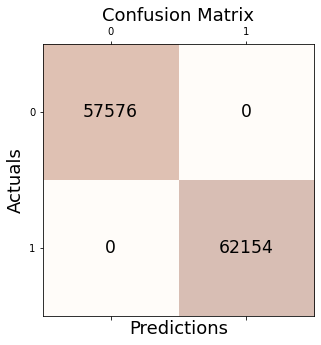

The confusion matrix shows us the number of :

* True positives : 57576 

* True negatives : 0 

* False positives: 0 

* False negatives: 62154 



In [161]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('The confusion matrix shows us the number of :\n')
print('* True positives :', conf_matrix[0][0] ,'\n')
print('* True negatives :', conf_matrix[0][1],'\n')
print('* False positives:', conf_matrix[1][0] ,'\n')
print('* False negatives:', conf_matrix[1][1] ,'\n')

# Comparing models predictions on application test

In [172]:
LR_target = app_test_LR['TARGET'] 
DT_target = app_test_DT['TARGET']
RF_target = app_test_RF['TARGET']

if LR_target.equals(DT_target):
    if LR_target.equals(RF_target):
        print("All three models found the same target values on application test.")
else: 
    print("All three models did not find the same target values on application test.")

All three models found the same target values on application test.


# Conclusion

The data given was very unbalanced, we had to use oversampling to balance it to get accurate models.

We can see that the least efficient model was the logistic regression.

As the bank, if the model predicts too many true positives, this is not an issue. The bank would not give the loan to someone who could have repaid it. This isn't so great for the clients.